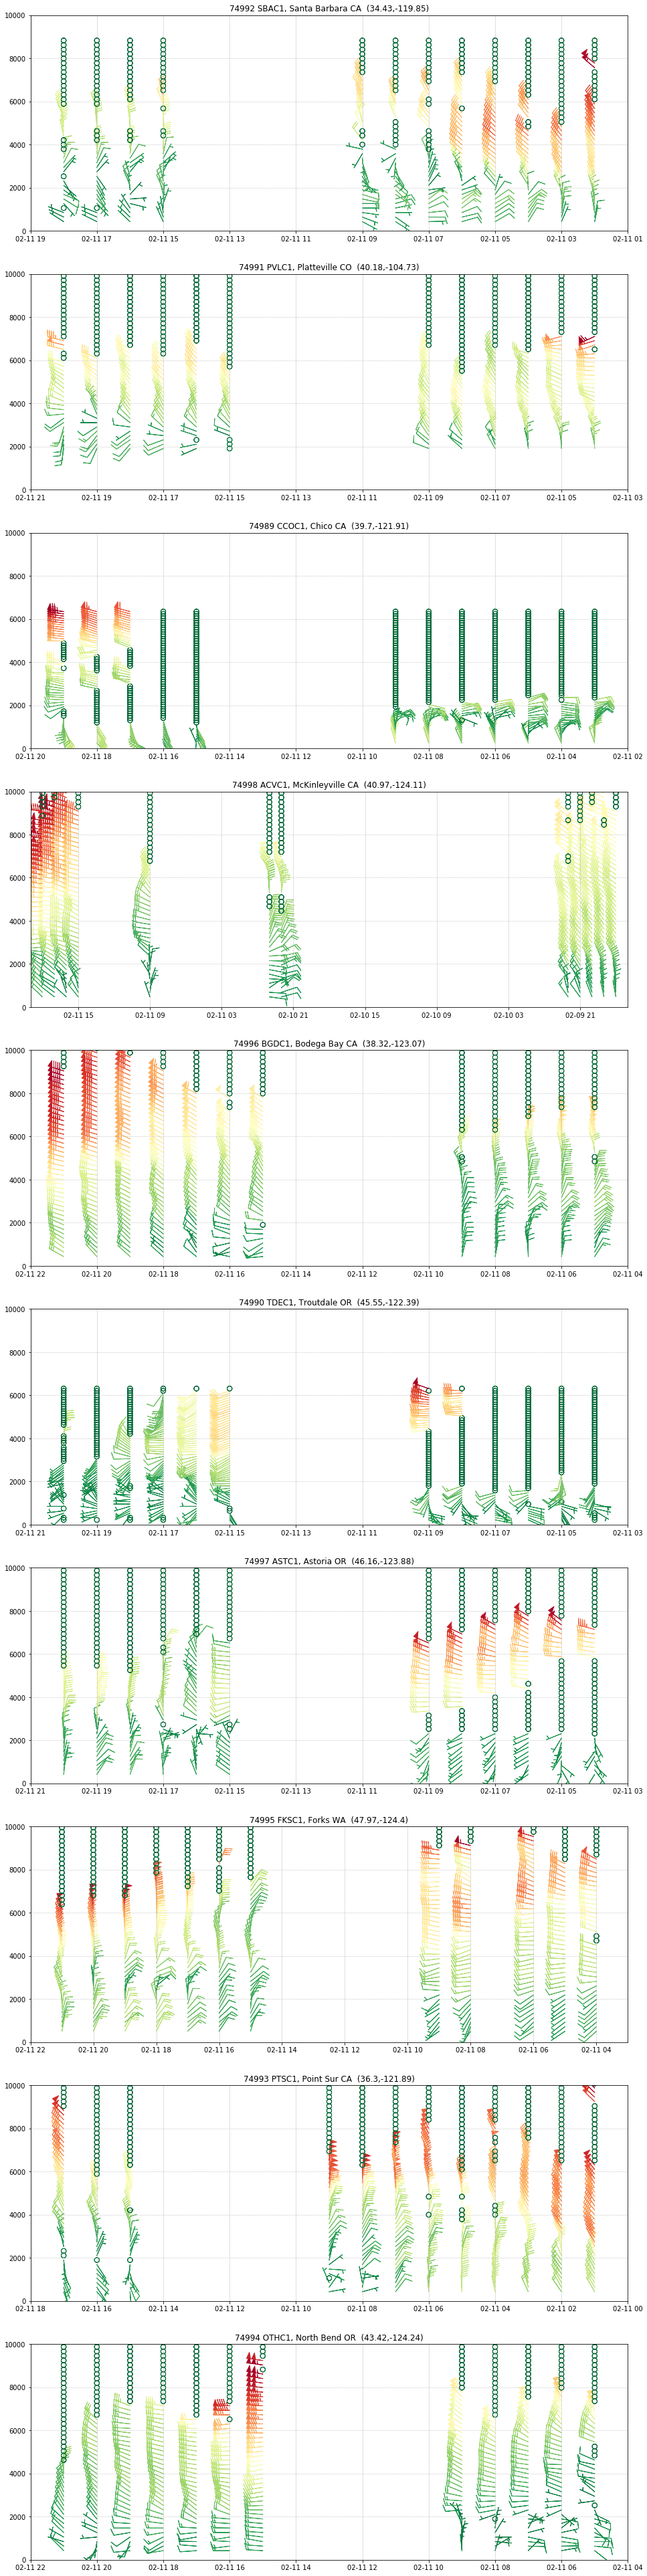

In [2]:
from awips.dataaccess import DataAccessLayer
from awips.tables import profiler
import matplotlib.tri as mtri
from datetime import datetime, timedelta
from matplotlib.dates import date2num
from metpy.units import units
import matplotlib.pyplot as plt
import numpy as np

# Query ESRL/PSD profiler data from Unidata AWIPS
DataAccessLayer.changeEDEXHost("js-157-49.jetstream-cloud.org")
request = DataAccessLayer.newDataRequest()
request.setDatatype("profiler")
profilerSites = DataAccessLayer.getAvailableLocationNames(request)

%matplotlib inline
fig = plt.figure(figsize=(16,7*len(profilerSites)))
    
for i, site in enumerate(profilerSites):
    request = DataAccessLayer.newDataRequest()
    request.setDatatype("profiler")
    request.setLocationNames(site)
    request.setParameters("uComponent","vComponent")

    # Request the last twelve hourly obs
    hrs=12
    requestTimes = DataAccessLayer.getAvailableTimes(request)[-1*hrs:]
    response = DataAccessLayer.getGeometryData(request,requestTimes)

    # Build arrays 
    u,v,times=[],[],[]
    for time in requestTimes:
        uu,vv,heights=[],[],[]
        for ob in response:
            if str(ob.getDataTime().getValidPeriod().start) == str(time):
                uu.append(float(ob.getString("uComponent")))
                vv.append(float(ob.getString("vComponent")))
                heights.append(float(ob.getLevel().translate(None, 'FHAG')))
        u.append(uu)
        v.append(vv)
        times.append(time.validPeriod.start)

    # Convert u,v components to knots and transpose arrays to match t,h
    u = (np.asarray(u, dtype=np.float32) * units('m/s')).to('knots').T
    v = (np.asarray(v, dtype=np.float32) * units('m/s')).to('knots').T
    t, h = np.meshgrid(times, heights)
    C = np.sqrt(u**2 + v**2)
    cmap=plt.cm.RdYlGn_r
       
    profilerName=str(profiler[site]['profilerName'])
    profilerId=str(profiler[site]['profilerId'])
    profilerLat=str(profiler[site]['latitude'])
    profilerLng=str(profiler[site]['longitude'])
    imgTitle=site +" "+ profilerId +", "+ profilerName +"  ("+ profilerLat +","+ profilerLng +")"
    
    ax = fig.add_subplot(len(profilerSites),1,i+1)
    ax.title.set_text(imgTitle)
    ax.barbs(date2num(t), h, u, v, C, cmap=cmap)
    ax.xaxis_date()
    ax.set_xlim(times[0]-timedelta(hours=1), times[-1]+timedelta(hours=1))
    ax.set_ylim(0,10000)
    ax.grid(axis='x', which='major', alpha=0.5)
    ax.grid(axis='y', which='major', linestyle=':')
    plt.gca().invert_xaxis()

fig.show()